In [1]:
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()

In [2]:
# Переопределим операцию деления с остатком
def mod(a, b):
    """
    возвращает ненулевой остаток от деления или делитель, если делится нацело
    """
    res = a % b
    return res if res else b

# Дискретизация непрерывной функции
def discretize(data, num):
    """
    >>> discretize(np.array([-3. , -1.5,  0. ,  1.5,  3. ]), 100)
    >>> (array([  0,  26,  50,  76, 100]), 0.06, -3.0)
    """
    data = data.astype(np.float32)
    data_min = data.min()
    delta = (data.max() - data_min) / num
    return ((data - data_min) / delta + 0.5).round().astype(int), delta, data_min

# Восстановление значений
def recover(discrete_values, delta, data_min):
    """
    >>> recover(*(array([  0,  26,  50,  76, 100]), 0.06, -3.0))
    >>> array([-3.  , -1.44,  0.  ,  1.56,  3.  ])
    """
    return discrete_values * delta + data_min

In [3]:
class CMAC:
    """
    CMAC - алгоритм для хранения, восстановления и интерполяции значений многомерной функции
    """
    def __init__(self, ro: int, mu: list, dim: int):
        """
        ro: кол-во активных ячеек памяти
        mem_size: кол-во всех ячеек памяти
        memory: массив (shape (1, mem_size)) весов
        dim: кол-во строк в матрице весов
        
        mu: вектор, размерности dim, использующийся для вычисления размера вектора весов,
        номеров активных ячеек памяти, максимальных значений по каждой координате 
        (см. формулы (10), (11), (12) в 1-й статье Аведьяна)
        """
        self.ro = ro
        self.dim = dim
        self.mu = np.array(mu)
        assert len(self.mu) == self.dim
        
        self.mem_size = self.mu.prod() * self.ro
        self.memory = np.zeros(self.mem_size)
        self.memory_n = np.zeros(self.mem_size)
        
    def get_active_cells(self, x: np.ndarray):
        """
        Возвращает ассоциативный вектор a(x) размерности (self.dim,) - в нем
        только единицы и нули. Единицы стоят на месте возбужденных ячеек памяти - нули - на
        невозбужденных
        """
#         if len(x.shape) == 1:
#             assert self.dim == 1
#         else:
#             assert len(x.shape) == 2 and x.shape[1] == self.dim
        
        M = np.zeros([self.dim, self.ro]) # матрица активных ячеек

        # для каждой row_num-ой координаты входящего вектор x
        # вычисляем self.ro номеров активных ячеек и записываем их
        # в строку M[row_num, :]
        for row_num in range(self.dim):
            # У числа t из R^n будет self.ro активных ячеек: t, t+1, ..., t + self.ro
            # номер столбца, куда записать текущий номер активной ячейки,
            # вычисляет функцией mod
            active_cell_num = x[row_num]
            pos = mod(x[row_num], self.ro)
            for col_num in range(pos-1, self.ro):
                M[row_num, col_num] = active_cell_num
                active_cell_num += 1
            for col_num in range(pos-1):
                M[row_num, col_num] = active_cell_num
                active_cell_num += 1
        
        M = M.T
        active_cells_vector = np.zeros(self.ro)

        # см. формулу (12) из 1-й статьи Аведьяна
        for i in range(self.ro):
            l = ([(M[i, 0]-1) * self.mu[1:].prod()] + [ ((M[i, j]-1) // self.ro) * self.mu[j+1:].prod() for j in range(1, self.dim) ])
            active_cells_vector[i] = sum(l) + 1
            
        return active_cells_vector
    
    def predict(self, x, return_active=False):
        """
        входящий вектор x однозначно определяет набор активных ячеек памяти.
        А сама функция, которую хранит CMAC, вычисляется по сумме активных ячеек памяти,
        умноженных на их веса
        """
        idx = self.get_active_cells(x).astype(int)
        self.memory_n[idx] += 1
        if return_active:
            return self.memory[idx].sum(), idx
        else:
            return self.memory[idx].sum()

    def train_step(self, x, y, use_second_layer=True, apply_noise_to_first_layer_output=True):
        """
        apply_noise_to_first_layer_output: наложить шум на выход первого слоя нейросети
        use_second_layer: использовать 2й слой
        """
        y_pred, idx = self.predict(x, return_active=True)
        
        if apply_noise_to_first_layer_output:
            y_pred += y_pred*np.random.rand()*np.random.randint(-1, 1) * 0.1
            
        d_w = float(y - y_pred) / self.ro
        
        if use_second_layer:
            self.memory[idx] += (d_w - self.memory[idx])/self.memory_n[idx]
        else:
            self.memory[idx] += d_w

In [4]:
def train(net, x, y, epochs, step = -1, use_second_layer=True, apply_noise_to_first_layer_output=True):
    sz = len(y)
    
    if step != -1:
        for j in range(step):
            tmp = np.random.randint(0, sz)
            net.train_step(x[tmp], y[tmp], use_second_layer, apply_noise_to_first_layer_output)
    else:
        epoch = 0
        i = 40
        while epoch < epochs:
            if i >= sz:
                i = 0
                
            net.train_step(x[i], y[i], use_second_layer, apply_noise_to_first_layer_output)
                
            epoch += 1
            i += 1

### Тестируем алгоритм для функции одной переменной (без шума и 2-го слоя)

In [14]:
def run_experiment(use_second_layer, apply_noise_to_first_layer_output):
    def one_pass(x, n_iter, arg):
        ro, mu, dim = arg[0], arg[1], arg[2]
        cmac = CMAC(ro, mu, dim)
        train(cmac, x, y, n_iter, -1, use_second_layer, apply_noise_to_first_layer_output)

        y_pred = np.array([cmac.predict(x1) for x1 in x])

        plt.plot(x, y_pred, color='green')
        plt.title(f"CMAC predictions, iters = {n_iter}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    # Генерирую данные
    data = np.linspace(-3, 3, 500)

    x, d_x, x_min = discretize(data, 100)
    x = x.reshape(-1, 1)

    x_r = recover(x, d_x, x_min)
    y = -x_r ** 3 + 10 * x_r + 20

    xmax = x.max()

    # Гиперпараметры
    ro = 8
    k = math.ceil(float(xmax - 1) / ro) + 1
    mu = [k]
    dim = 1

    plt.plot(x, y)
    plt.title("Original function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()

    one_pass(x, 1, (ro, mu, dim))
    one_pass(x, 2, (ro, mu, dim))
    one_pass(x, 5, (ro, mu, dim))
    one_pass(x, 100, (ro, mu, dim))

    one_pass(x, 1000, (ro, mu, dim))
    one_pass(x, 3000, (ro, mu, dim))

In [16]:
np.random.randint(0, 10, 1)

array([9])

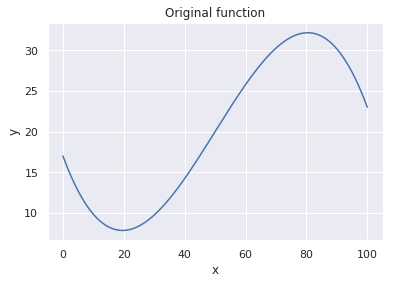

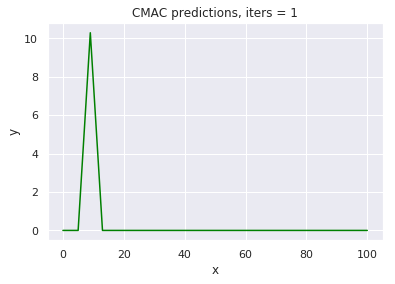

In [6]:
def one_pass(x, y, n_iter, arg):
    ro, mu, dim = arg[0], arg[1], arg[2]
    cmac = CMAC(ro, mu, dim)
    train(cmac, x, y, n_iter, -1, use_second_layer=False, apply_noise_to_first_layer_output=False)

    y_pred = np.array([cmac.predict(x1) for x1 in x])

    plt.plot(x, y_pred, color='green')
    plt.title(f"CMAC predictions, iters = {n_iter}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Генерирую данные
data = np.linspace(-3, 3, 500)

x, d_x, x_min = discretize(data, 100)
x = x.reshape(-1, 1)

x_r = recover(x, d_x, x_min)
y = -x_r ** 3 + 10 * x_r + 20

xmax = x.max()

# Гиперпараметры
ro = 4
k = math.ceil(float(xmax - 1) / ro) + 1
mu = [k]
dim = 1

plt.plot(x, y)
plt.title("Original function")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

one_pass(x, y, 1, (ro, mu, dim))

In [18]:
def train(net, x, y, epochs, step = -1, use_second_layer=True, apply_noise_to_first_layer_output=True):
    sz = len(y)
    
    if step != -1:
        for j in range(step):

            net.train_step(x[50], y[50], use_second_layer, apply_noise_to_first_layer_output)
    else:
        epoch = 0
        i = 40
        while epoch < epochs:
            if i >= sz:
                i = 0
                
            net.train_step(x[i], y[i], use_second_layer, apply_noise_to_first_layer_output)
                
            epoch += 1
            i += 1

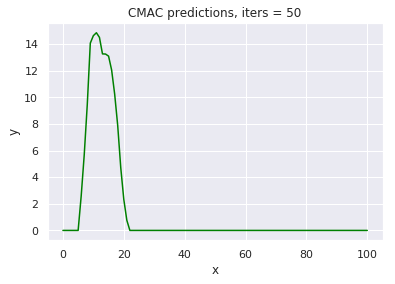

In [20]:
one_pass(x, y, 50, (ro, mu, dim))

In [21]:
net.train_step(x[50], y[50], use_second_layer, apply_noise_to_first_layer_output)

NameError: name 'net' is not defined

In [ ]:
def one_pass(x, y, n_iter, arg):
    ro, mu, dim = arg[0], arg[1], arg[2]
    cmac = CMAC(ro, mu, dim)
    train(cmac, x, y, n_iter, -1, use_second_layer=False, apply_noise_to_first_layer_output=False)

    y_pred = np.array([cmac.predict(x1) for x1 in x])

    plt.plot(x, y_pred, color='green')
    plt.title(f"CMAC predictions, iters = {n_iter}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

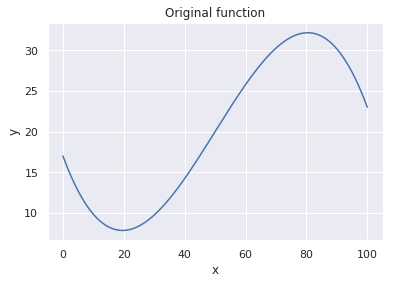

[[  0]
 [  1]
 [  1]
 [  1]
 [  1]
 [  2]
 [  2]
 [  2]
 [  2]
 [  2]
 [  3]
 [  3]
 [  3]
 [  3]
 [  3]
 [  4]
 [  4]
 [  4]
 [  4]
 [  4]
 [  5]
 [  5]
 [  5]
 [  5]
 [  5]
 [  6]
 [  6]
 [  6]
 [  6]
 [  6]
 [  7]
 [  7]
 [  7]
 [  7]
 [  7]
 [  8]
 [  8]
 [  8]
 [  8]
 [  8]
 [  9]
 [  9]
 [  9]
 [  9]
 [  9]
 [ 10]
 [ 10]
 [ 10]
 [ 10]
 [ 10]
 [ 11]
 [ 11]
 [ 11]
 [ 11]
 [ 11]
 [ 12]
 [ 12]
 [ 12]
 [ 12]
 [ 12]
 [ 13]
 [ 13]
 [ 13]
 [ 13]
 [ 13]
 [ 14]
 [ 14]
 [ 14]
 [ 14]
 [ 14]
 [ 15]
 [ 15]
 [ 15]
 [ 15]
 [ 15]
 [ 16]
 [ 16]
 [ 16]
 [ 16]
 [ 16]
 [ 17]
 [ 17]
 [ 17]
 [ 17]
 [ 17]
 [ 18]
 [ 18]
 [ 18]
 [ 18]
 [ 18]
 [ 19]
 [ 19]
 [ 19]
 [ 19]
 [ 19]
 [ 20]
 [ 20]
 [ 20]
 [ 20]
 [ 20]
 [ 21]
 [ 21]
 [ 21]
 [ 21]
 [ 21]
 [ 22]
 [ 22]
 [ 22]
 [ 22]
 [ 22]
 [ 23]
 [ 23]
 [ 23]
 [ 23]
 [ 23]
 [ 24]
 [ 24]
 [ 24]
 [ 24]
 [ 24]
 [ 25]
 [ 25]
 [ 25]
 [ 25]
 [ 25]
 [ 26]
 [ 26]
 [ 26]
 [ 26]
 [ 26]
 [ 27]
 [ 27]
 [ 27]
 [ 27]
 [ 27]
 [ 28]
 [ 28]
 [ 28]
 [ 28]
 [ 28]
 [ 29]
 [ 29]
 [ 29]

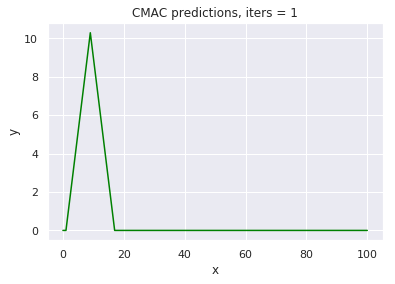

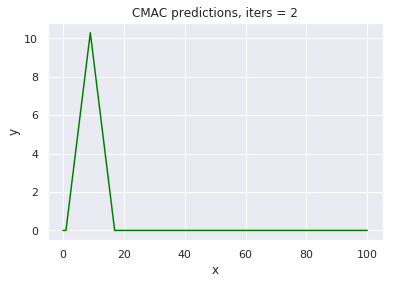

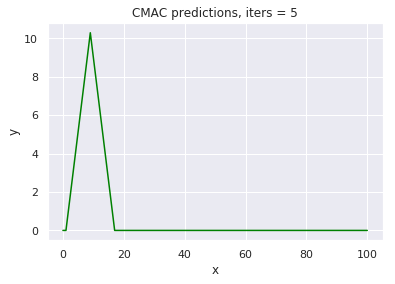

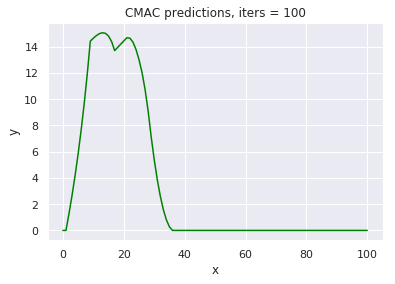

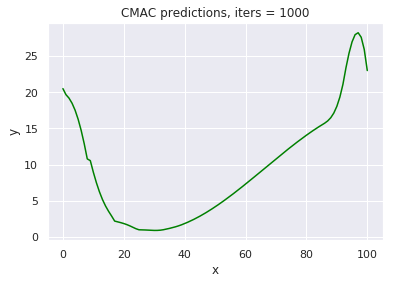

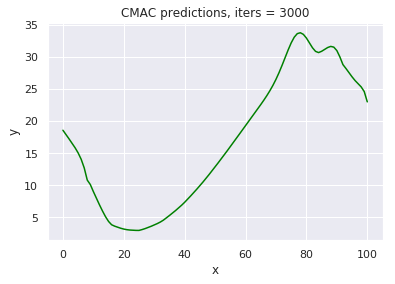

In [15]:
run_experiment(False, False)

### Тестируем алгоритм для функции одной переменной (С шумом и 2-м слоем)

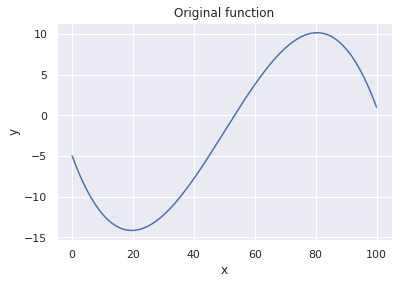

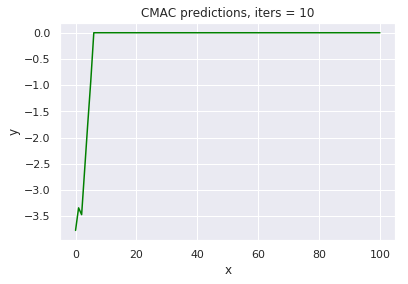

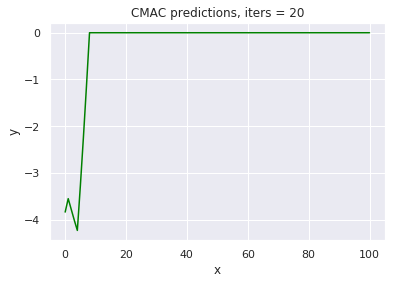

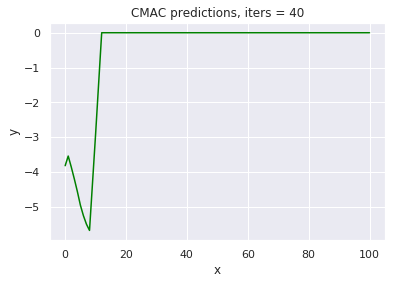

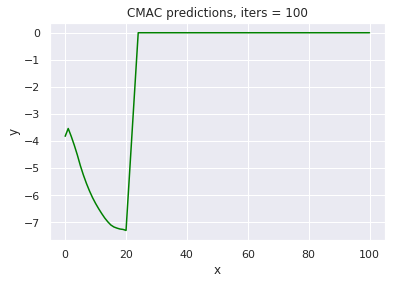

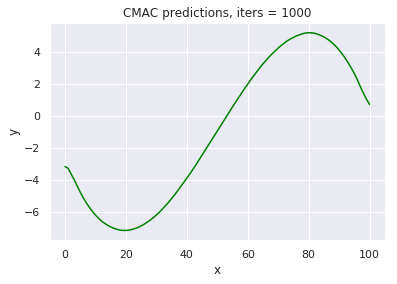

In [125]:
run_experiment(True, True)

### Только полож значения функции. Без шума и 2-го слоя

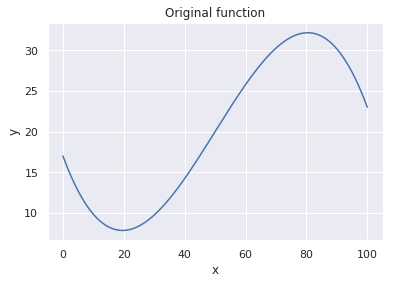

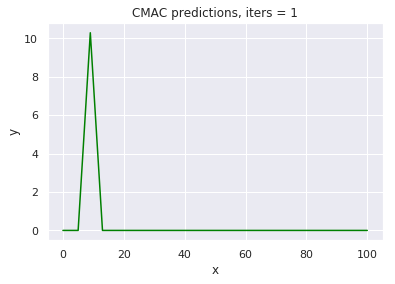

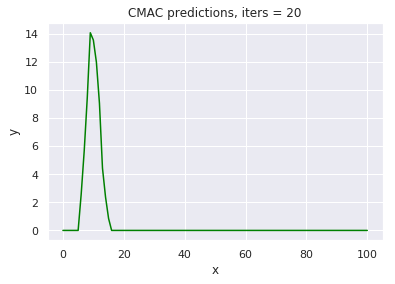

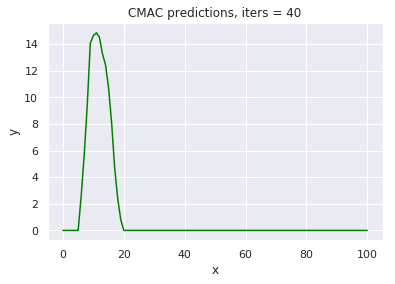

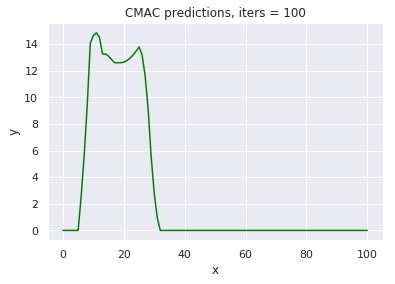

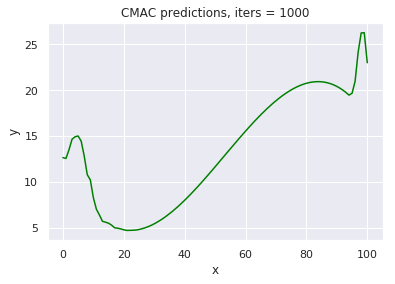

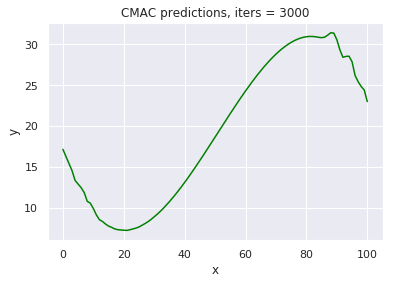

In [8]:
run_experiment(False, False)

### С шумом и без 2-го слоя

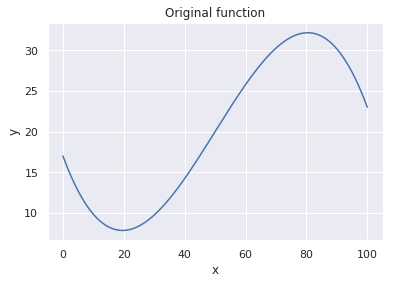

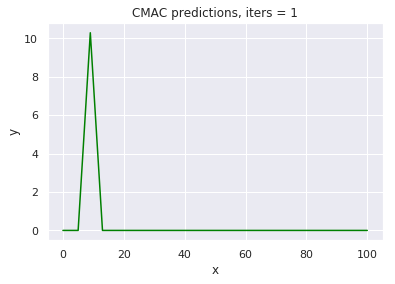

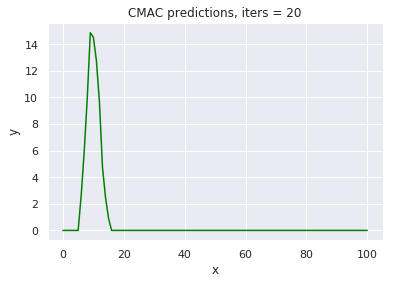

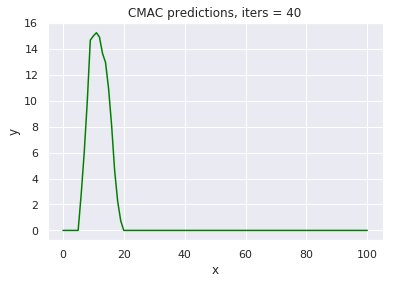

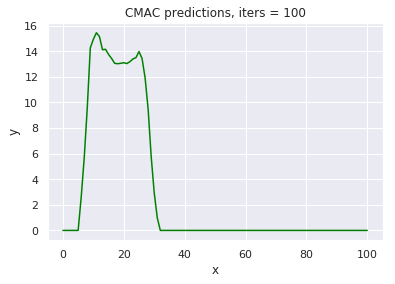

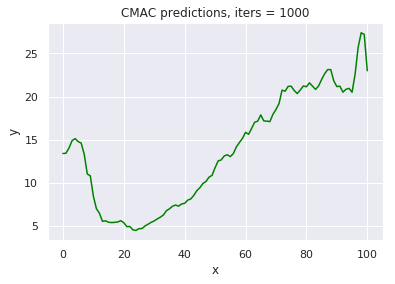

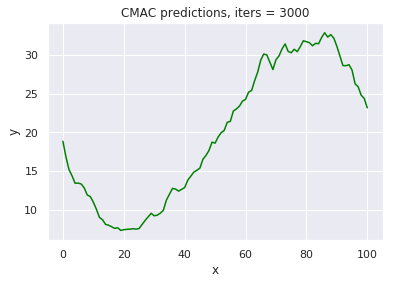

In [9]:
run_experiment(False, True)

### Функция двух переменных (Без шума и второго слоя)

In [117]:
def run_experiment(use_second_layer, apply_noise_to_first_layer_output):
    def train(net, x, y, epochs, step = -1):
        sz = len(y)

        if step != -1:
            for j in range(step):
                tmp = np.random.randint(0, sz)
                net.train_step(x[tmp], y[tmp], use_second_layer, apply_noise_to_first_layer_output)
        else:
            for epoch in range(epochs):
                for i in range(sz):
                    net.train_step(x[i], y[i], use_second_layer, apply_noise_to_first_layer_output)


    # Данные
    n_epochs = 10
    n_intervals = 50

    x_raw = np.linspace(0, 10, 100)
    x, d_x, x_min = discretize(x_raw, n_intervals)
    y_raw = np.linspace(0, 10, 100)
    y, d_y, y_min = discretize(y_raw, n_intervals)

    X, Y = np.tile(x, (y.shape[0], 1)).T, np.tile(y, (x.shape[0], 1))

    data = [(X[i, j], Y[i, j]) for i in range(x.shape[0])
                               for j in range(y.shape[0])]
    #x^2 - 5y - 4y^2 + 5
    Z = -recover(X, d_x, x_min) ** 2 - 5 * recover(X, d_x, x_min) + 4 * recover(Y, d_y, y_min) **2 + 5

    # Гиперпараметры
    ro = 4
    mu = [x.max(), y.max()]
    mu = np.array(list(map(math.ceil,
                           [ float(a - 1) / ro for a in mu ]))) + 1
    dim = 2

    # Обучаем сеть
    fig = plt.figure(figsize=(15, 12))

    cmac = CMAC(ro, mu, dim)
    ax = None

    for i in range(4):
        train(cmac, data, Z.reshape(-1), n_epochs)
        ax = fig.add_subplot('22{}'.format(i+1), projection='3d')
        Z_pred = np.array([ cmac.predict(x1) for x1 in data ])
        Z_pred = Z_pred.reshape(x.shape[0], y.shape[0])
        ax.plot_surface(X, Y, Z_pred, color='red')
        plt.title('n_epochs = {}'.format((i+1) * n_epochs))
        print(np.mean((Z - Z_pred) ** 2))
    plt.show()
    ax.plot_surface(X, Y, Z, color='blue');
    #plt.plot_surface(X, Y, Z, color="blue")

1.0823307296746874
0.3384917051525071
0.15554790789680076
0.08865824465630065


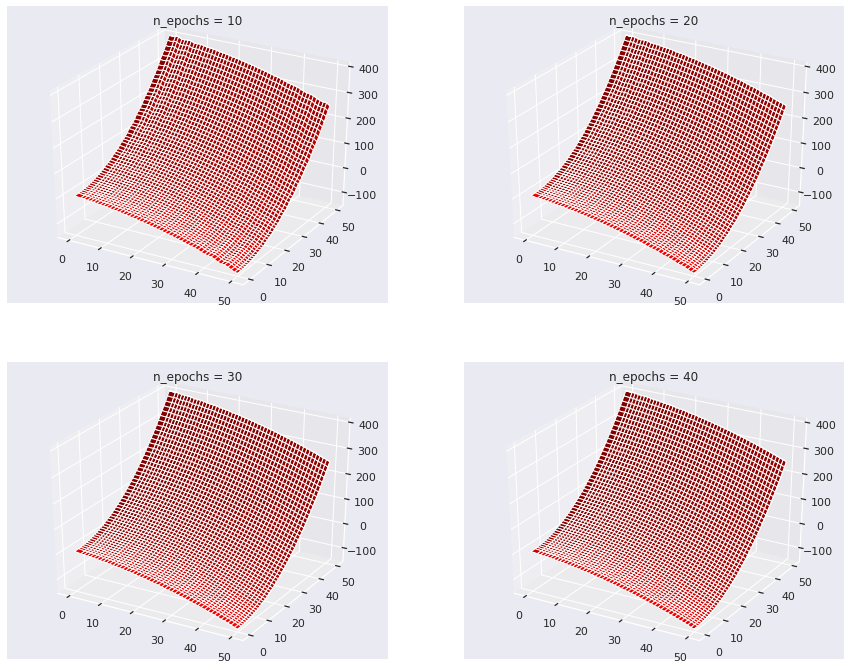

In [118]:
run_experiment(False, False)

### Функция двух переменных (С шумом и вторым слоем)

5769.288475850703
5769.714475032489
5769.833976381739
5770.0610362041425


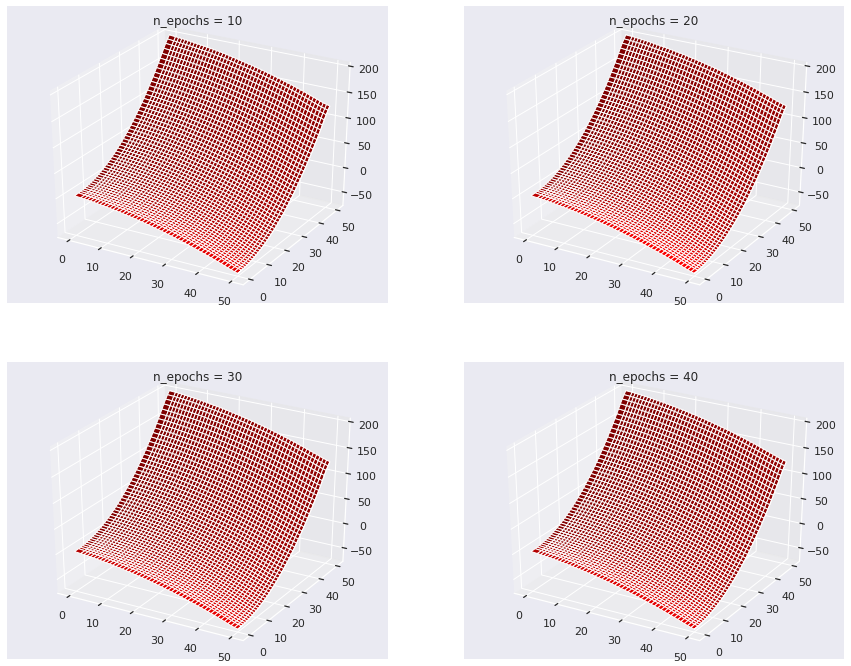

In [119]:
run_experimentxperiment(True, True)

### Функция двух переменных (С шумом без 2-го слоя)

42.17916998173795
46.166841699810824
43.81215844926381
53.67592196633249


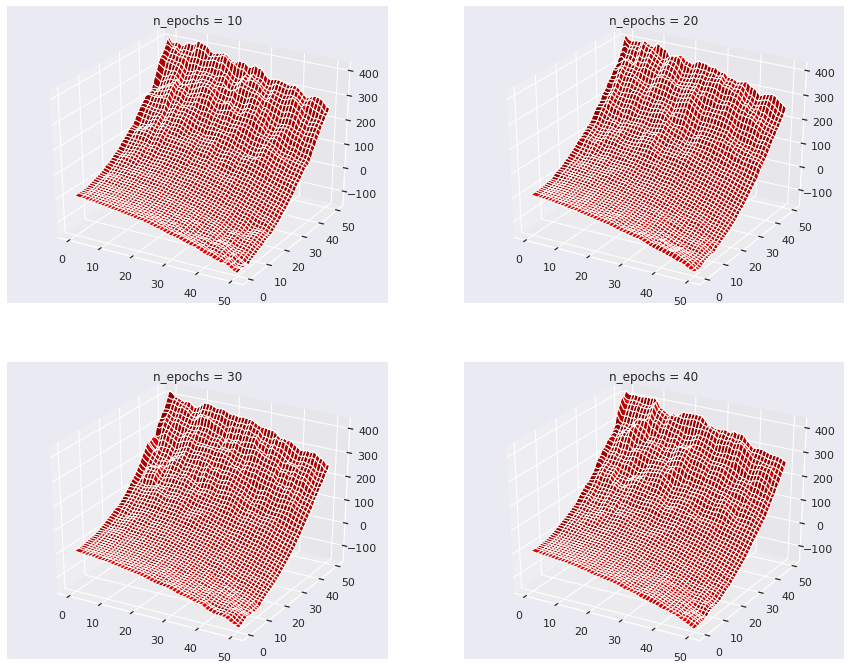

In [120]:
run_experiment(False, True)

### Базисные функции

23530.32957072001


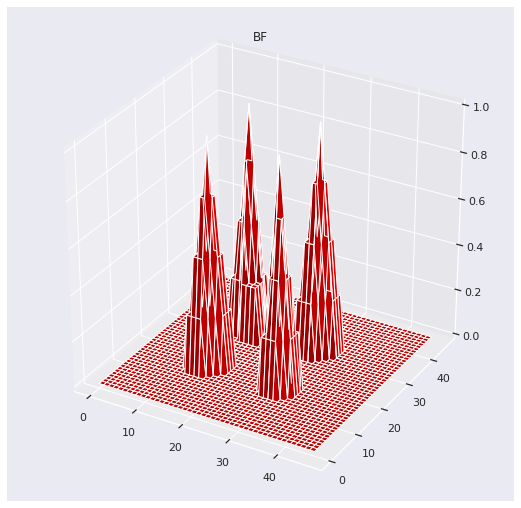

In [57]:
n_intervals = 45

x_raw = np.linspace(0, 10, 100)
x, d_x, x_min = discretize(x_raw, n_intervals)
y_raw = np.linspace(0, 10, 100)
y, d_y, y_min = discretize(y_raw, n_intervals)

X, Y = np.tile(x, (y.shape[0], 1)).T, np.tile(y, (x.shape[0], 1))

data = [(X[i, j], Y[i, j]) for i in range(x.shape[0])
                           for j in range(y.shape[0])]

# Гиперпараметры
ro = 4
mu = [x.max(), y.max()]
mu = np.array(list(map(math.ceil,
                       [ float(a - 1) / ro for a in mu ]))) + 1
dim = 2

# Обучаем сеть

cmac = CMAC(ro, mu, dim)
cmac.train_step([15,15], ro)
cmac.train_step([30,15], ro)
cmac.train_step([15,30], ro)
cmac.train_step([30,30], ro)

ax = None
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot('22{}'.format(1), projection='3d')
Z_pred = np.array([ cmac.predict(x1) for x1 in data ])
Z_pred = Z_pred.reshape(x.shape[0], y.shape[0])
ax.plot_surface(X, Y, Z_pred/ro,  color='red')
plt.title('BF')
print(np.mean((Z - Z_pred) ** 2))

### Выброс для функции с разрывом

0.1089
0.1089
0.1089
0.1089


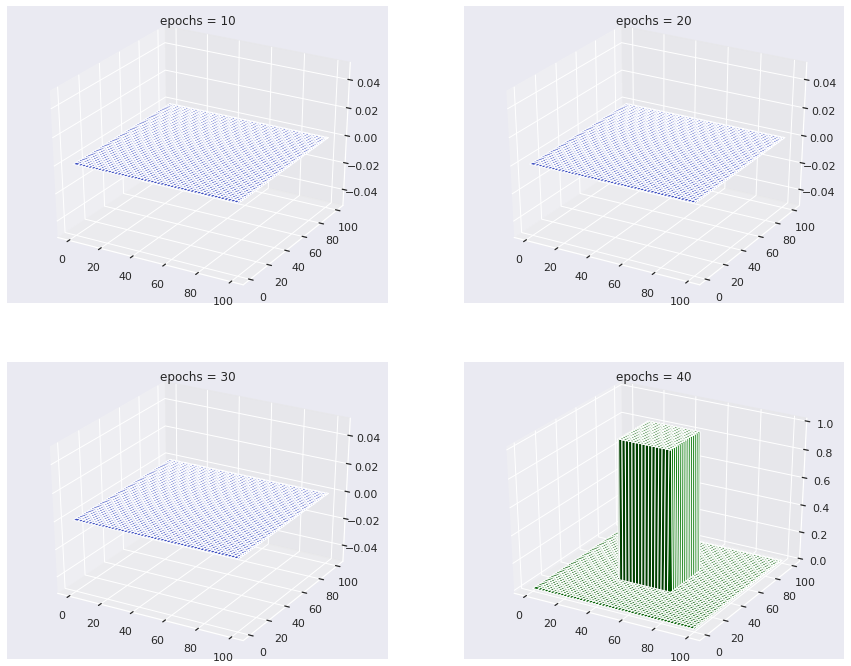

In [58]:
# Данные
n_epochs = 10
n_intervals = 100

x_raw = np.linspace(0, 20, 100)
x, d_x, x_min = discretize(x_raw, n_intervals)
y_raw = np.linspace(0, 10, 100)
y, d_y, y_min = discretize(y_raw, n_intervals)

X, Y = np.tile(x, (y.shape[0], 1)).T, np.tile(y, (x.shape[0], 1))

data = [(X[i, j], Y[i, j]) for i in range(x.shape[0])
                           for j in range(y.shape[0])]

Z = np.zeros_like(Y)
Z[X>33] = 1
Z[Y>33] = 1
Z[X>66] = 0
Z[Y>66] = 0
Z[X<34] = 0
Z[Y<34] = 0

# Гиперпараметры
ro = 2
mu = [x.max(), y.max()]
mu = np.array(list(map(math.ceil,
                       [ float(a - 1) / ro for a in mu ]))) + 1
dim = 2

# Обучаем сеть
fig = plt.figure(figsize=(15, 12))

cmac = CMAC(ro, mu, dim)
ax = None

for i in range(4):
    train(cmac, data, Z.reshape(-1), n_epochs)
    ax = fig.add_subplot('22{}'.format(i+1), projection='3d')
    Z_pred = np.array([ cmac.predict(x1) for x1 in data ])
    Z_pred = Z_pred.reshape(x.shape[0], y.shape[0])
    ax.plot_surface(X, Y, Z_pred, cmap = cm.coolwarm, color='red')
    plt.title('epochs = {}'.format((i+1) * n_epochs))
    print(np.mean((Z - Z_pred) ** 2))

ax.plot_surface(X, Y, Z, color='green');

Добавить разрывы сбоку

калман, винер, 